<a href="https://colab.research.google.com/github/NicolaViolante/ProgettoML/blob/main/Violante_Nicola(0362469).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traccia T4 - Riconoscimento animali da tracce audio

L' obiettivo del seguente elaborato è quello di andare a costruire due differenti modelli che riescano a riconoscere diversi animali(nel caso particolare gatti, cani e delfini) a partire dalla registrazione del loro verso.

Il primo modello prende in input direttamente la forme d'onda associata a ciascuna traccia considerabile come una sequenza, mentre il secondo modello prende in input lo spettrogramma di ciascuna traccia, che è la rappresentazione grafica dell'intensità del suono in funzione del tempo e della frequenza.

#Preparazione dei dati

Inizio con l'importare le diverse librerie e i diversi moduli che mi serviranno per svilppare il codice per il mio progetto. In particolare uso:

*   Tensorflow: la libreria fondamentale per la costruzione dei miei modelli, per la gestione dei dati, il lavoro con tensori e l'ottimizzazione dei dati
*   Keras: modulo di tensorflow che semplifica creazione e addestramento delle reti neurali grazie a suoi strumenti messi a disposizione
*   Numpy: per lavorare e manipolare i tensori
*   Sklearn: usata per dividere il dataset in modo da costituire i diversi set, inoltre usata per analizzare le prestazioni del modello dopo la costruzione della matrice di confusione
*   Matplotlib: una libreria di visualizzazione dati che viene utilizzata per tracciare grafici
*   Librosa: usata per modificare le tracce audio durante l'augmentation e visualizzazione di dati audio, in particolare per tracciare gli spettrogrammi
*   Pandas: usata per tracciare i grafici di apprendimento e per organizzare i dati durante l'analisi


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, Dense, Add, GlobalAveragePooling1D, Dropout, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Lambda, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import librosa
import pandas as pd

In questa parte di codice procedo a costruire i dataset che mi serviranno durante la fase d'addestramento e di test. In particolare utilizzo la funzione audio_dataset_from_directory(). Tramite questa specifico:

*   la directory nella quale sono presenti i dati
*   il modo d'estrazione dati in formato streaming
*   la lunghezza dell'audio in numero di campioni(se più corto della quantità indicata sarà paddato alla fine)
*   il modo in cui saranno codificate le etichette(one-hot)

Per quanto riguarda i dati forniti per questo progetto sono distribuiti in due diverse cartelle(train e test). Entrambe queste cartelle hanno tre sottocartelle nelle quali sono distribuiti i dati in base alla specie animale in questione. Per quanto riguarda la distribuzione dei dati è abbastanza omogenea sia in train che test.

Gli input che ho deciso di prendere in considerazione sono audio della lunghezza di tre secondi, questa scelta è stata fatta puramente per motivi computazionali.

In [ ]:
train_dir = "/content/drive/MyDrive/cats_dogs_dolphins/train"
test_dir = "/content/drive/MyDrive/cats_dogs_dolphins/test"

train_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    batch_size=None,
    output_sequence_length=48000,
    label_mode="categorical",
)

test_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=None,
    output_sequence_length=48000,
    label_mode="categorical",
)

Found 325 files belonging to 3 classes.
Found 98 files belonging to 3 classes.


Qui faccio semplicemente un controllo sui nomi delle classi trovate.

In [ ]:
class_names = train_dataset.class_names
print(f"Classi trovate: {class_names}")

Classi trovate: ['cat', 'dog', 'dolphin']


In questa parte del codice definisco varie tipologie di funzioni per fare data augmentation. Inoltre ad ogni trasformazione associo una probabilità.

In [ ]:
def add_white_noise(audio, noise_level_min=0.005, noise_level_max=0.03):
    noise_level = np.random.uniform(noise_level_min, noise_level_max)
    noise = np.random.randn(len(audio))
    return np.clip(audio + noise_level * noise, -1.0, 1.0)

def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def reverse_audio(audio, sr):
    return audio[::-1]

def change_volume(audio, sr, min_gain=0.6, max_gain=1.5):
    gain = np.random.uniform(min_gain, max_gain)
    return np.clip(audio * gain, -1.0, 1.0)

def apply_random_augmentation(audio, sr, label, augmentations_with_prob):

    label_idx = np.argmax(label)

    for fn, prob, apply_to in augmentations_with_prob:
        if label_idx in apply_to and np.random.rand() < prob:
            audio = fn(audio, sr)
    return audio

augmentations_with_prob = [
    (lambda x, sr: add_white_noise(x, 0.001, 0.02), 0.6,[0,1,2]),
    (lambda x, sr: time_stretch(x, np.random.uniform(0.85, 1.15)), 0.4,[0,1]),
    (lambda x, sr: pitch_shift(x, sr, np.random.randint(-3, 3)), 0.5,[0]),
    (lambda x, sr: reverse_audio(x, sr), 0.1,[0]),
    (lambda x, sr: change_volume(x, sr, 0.7, 1.3), 0.5,[0,1,2]),
]

Sucessivamente vado a costruire delle liste dove inserirò prima i dati provenienti dal dataset e poi i nuovi dati costruiti a seguito dell'augmentation dei dati.

In questa fase inoltre mi assicuro che i nuovi dati abbiano le stesse dimensioni dei dati fornitimi originariamente.



In [ ]:
train_audio_list, train_labels_list = [], []
test_audio_list, test_labels_list = [], []

for audio, label in train_dataset:
    audio_np = audio.numpy().squeeze()
    label_np = label.numpy()

    train_audio_list.append(audio_np)
    train_labels_list.append(label_np)

    augmented_audio = apply_random_augmentation(audio_np, 16000, label_np, augmentations_with_prob)

    if len(augmented_audio) > 48000:
        augmented_audio = augmented_audio[:48000]
    else:
        augmented_audio = np.pad(augmented_audio, (0, 48000 - len(augmented_audio)), mode="constant")

    train_audio_list.append(augmented_audio)
    train_labels_list.append(label_np)

for audio, label in test_dataset:
    test_audio_list.append(audio.numpy().squeeze())
    test_labels_list.append(label.numpy())

train_audio = tf.convert_to_tensor(train_audio_list, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels_list, dtype=tf.float32)
test_audio = tf.convert_to_tensor(test_audio_list, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels_list, dtype=tf.float32)

In questa fase mi preoccupo di normalizzare i dati attraverso la standardizzazione. L'obiettivo è quello di migliorare la robustezza del modello, migliorare la convergenza e ridurre la varianza tra i diversi campioni.

In [ ]:
mean = tf.reduce_mean(train_audio)
std = tf.math.reduce_std(train_audio)
train_audio = (train_audio - mean) / std
test_audio = (test_audio - mean) / std

Qui faccio semplicemente dei controlli sulla dimensionalità per verificare che tutto sia andato correttamente e controllare la nuova dimensione dei dati di training e test.

In [ ]:
print("Train audio shape:", train_audio.shape)
print("Train labels shape:", train_labels.shape)
print("Test audio shape:", test_audio.shape)
print("Test labels shape:", test_labels.shape)

Train audio shape: (650, 48000)
Train labels shape: (650, 3)
Test audio shape: (98, 48000)
Test labels shape: (98, 3)




In questa fase decido di ottenere training set e validation set sfruttando i dati provenienti dalla cartella train. Inizialmente avevo pensato di ottenere i dati di validation dalla cartella test(nonostante sappia che nella realtà i dati di test non vanno toccati) a causa dei pochi dati a disposizione e lo squilibrio tra le proporzioni che avrei avuto sfruttando i dati di training.

Ho potuto estrarre i dati di validation da quelli di training poiche ho utilizzato data augmentation. Ho scelto di estrarre il 20% dei dati di training per la validation cosi che la distribuzione tra i vari set fosse:


*   **70%** dati nel training set
*   **17%** dati nel validation set
*   **13%** dati nel test set



In [ ]:
train_audio_np, val_audio_np, train_labels_np, val_labels_np = train_test_split(
    train_audio.numpy(),
    train_labels.numpy(),
    test_size=0.2,
    random_state=42,
    stratify=train_labels.numpy()
)

train_audio = tf.convert_to_tensor(train_audio_np)
val_audio = tf.convert_to_tensor(val_audio_np)
train_labels = tf.convert_to_tensor(train_labels_np)
val_labels = tf.convert_to_tensor(val_labels_np)

A seguito della divisione, ho deciso di fare un ulteriore controllo per verificare che valori e labels associate siano state separate in modo corretto.

In [ ]:
print(f"Train shape: {train_audio.shape}, Labels: {train_labels.shape}")
print(f"Validation shape: {val_audio.shape}, Labels: {val_labels.shape}")
print(f"Test shape: {test_audio.shape}, Labels: {test_labels.shape}")

unique, counts = np.unique(np.argmax(train_labels.numpy(), axis=1), return_counts=True)
print(f"Distribuzione delle classi nel training set: {dict(zip(class_names, counts))}")

unique, counts = np.unique(np.argmax(val_labels.numpy(), axis=1), return_counts=True)
print(f"Distribuzione delle classi nel validation set: {dict(zip(class_names, counts))}")

unique, counts = np.unique(np.argmax(test_labels.numpy(), axis=1), return_counts=True)
print(f"Distribuzione delle classi nel test set: {dict(zip(class_names, counts))}")


Train shape: (520, 48000), Labels: (520, 3)
Validation shape: (130, 48000), Labels: (130, 3)
Test shape: (98, 48000), Labels: (98, 3)
Distribuzione delle classi nel training set: {'cat': 200, 'dog': 136, 'dolphin': 184}
Distribuzione delle classi nel validation set: {'cat': 50, 'dog': 34, 'dolphin': 46}
Distribuzione delle classi nel test set: {'cat': 39, 'dog': 28, 'dolphin': 31}


# Modello 1 - Analisi della forma d'onda

In questo primo modello prendo in input le forme d'onda. Queste possono essere viste come dati che hanno una struttura a griglia con topologia 1D. Per il training di questo modello è necessaria la GPU in quanto, in assenza di questa, la durata delle epoche di training avrebbe un costo a livello temporale insostenibile. Non avendo a disposizione una GPU nativa, ho dovuto utilizzare quella messa a disposizione da Google Colab.

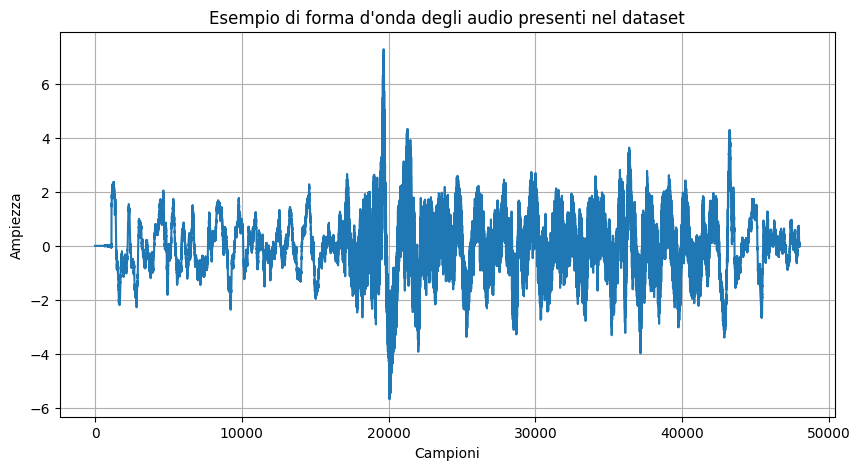

In [ ]:
sample_audio = train_audio[0]

plt.figure(figsize=(10, 5))
plt.plot(sample_audio)
plt.title("Esempio di forma d'onda degli audio presenti nel dataset")
plt.xlabel("Campioni")
plt.ylabel("Ampiezza")
plt.grid(True)
plt.show()


Per affrontare questo problema ho preso spunto dal modello presentato brevemente a lezione WaveNet. Questa è una rete neurale convoluzionale autoregressiva sviluppata per la sintesi vocale. Tuttavia, il suo principio è stato adattato anche per la classificazione audio.

Ho costruito il residual block in modo che fosse un unità di calcolo composta da convoluzioni dilatate, normalizzazione batch e connessioni residuali. Per quanto riguarda i diversi parametri in input:

*   x ➡ input del blocco, un tensore 1D
*   skip_outputs ➡ lista in cui vengono salvati output dei blocchi per una somma finale
*   filters ➡ numero di filtri usati per la convoluzione
*   kernel_size ➡ dimensione del kernel per la convoluzione
*   dilation_rate ➡ per indicare il tasso di dilatazione
*   regularizer ➡ per vincolo sui pesi del modello

Per quanto riguarda la strutturea del blocco, questo è formato da 2 livelli convoluzionali 1D, entrambi seguiti da livelli che fanno batch normalization per stabilizzare l'addestramento e migliorare la generalizzazione.

Successivamente è presente una connessione residuale che somma l'input originale con l'output convoluzionale per preservare il flusso dell'informazione evitando il problema del vanishing gradient.

Infine l'output viene salvato in skip_outputs in modo da creare una connessione diretta tra i livelli iniziali e quelli finali.



In [ ]:
def residual_block(x, skip_outputs, filters, kernel_size, dilation_rate, regularizer=None):

    conv = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal", activation="relu", kernel_regularizer=regularizer)(x)
    conv = BatchNormalization()(conv)
    conv = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal", kernel_regularizer=regularizer)(conv)
    conv = BatchNormalization()(conv)

    residual_output = Add()([x, conv])

    skip_outputs.append(conv)

    return residual_output

Qui definisco il modello vero e proprio. Per quanto riguarda l'input è una sequenza monodimensionale. La rete sarà composta da un numero di blocchi data dal prodotto num_blocks x num_stacks. Per quanto riguarda il regolarizzatore ho deciso di usare l2 per penalizzare i pesi grandi. Come descritto in WaveNet ho usato una dilatazione esponenziale per catturare delle relazioni a lungo termine.

Dopo i cicli for annidati vi è la somma delle skip connections salvate durante la costruzione della rete, questo permette al modello di avere accesso alle features apprese in ogni blocco.

Successivamente grazie al global pooling riassumo tutte le informazioni ottenute in un unico valore.

Infine ho uno strato completamente connesso formato da 128 neuroni, non tutti attivi per tentare di ridurre il fenomeno dell'overfitting.

Per quanto riguarda il layer di output, grazie alla softmax siamo sicuri che la somma delle probabilità delle diverse classi sia 1, questo permette che il modello restituisca una probabilità per ogni categoria.

In [ ]:
def create_wavenet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = inputs
    num_blocks = 6
    num_stacks = 2
    filters = 64
    kernel_size = 3
    regularizer = l2(0.01)

    skip_outputs = []

    for _ in range(num_stacks):
        dilation_rate = 1
        for _ in range(num_blocks):
            x = residual_block(x, skip_outputs, filters, kernel_size, dilation_rate, regularizer)
            dilation_rate *= 2
            if dilation_rate > 16:
                dilation_rate = 1

    x = Add()(skip_outputs)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In questa fase vi è la preparazione e la compilazione del modello, inoltre eseguo la funzione summary() sul modello in modo da averne una visione globale. Ho usato l'ottimizzatore Adam con un passo per aggiornare i pesi molto piccolo, per la loss ho utilizzato la categorical cross-entropy per misurare quanto il modello si discosti dalle labels reali durante l'addestramento, il modello tanto più si discosta, tanto più viene penalizzato. Infine come metrica ho definito l'accuratezza, che valuta la percentuale di predizioni corrette fatte dal modello.


In [ ]:
input_shape = (48000, 1)
num_classes = len(class_names)
model = create_wavenet_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 48000, 64)      │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48000, 64)      │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 48000, 64)      │         12,352 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48000, 64)      │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48000, 64)      │              0 │ input_layer[0][0],     │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 48000, 64)      │         12,352 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 48000, 64)      │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 48000, 64)      │         12,352 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 48000, 64)      │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 48000, 64)      │              0 │ add[0][0],             │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 48000, 64)      │         12,352 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 48000, 64)      │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 48000, 64)      │         12,352 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 48000, 64)      │            256 │ conv1d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 299,203 (1.14 MB)

 Trainable params: 296,131 (1.13 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="categorical_crossentropy", metrics=["accuracy"])

Qui addestro il modello, utilizzo l'early stopping per evitare l'overfitting e migliorare l'efficienza nell'addestramento, il valore osservato è la validation loss e, se non vi è un miglioramento per un determinato numero di epoche, l'addestramento viene interrotto ripristinando i pesi trovati per il valore migliore. Inoltre se non vi è un miglioramento per un altro determinato numero di epoche il learning rate viene diminuito in modo da migliorare convergenza e oscillazioni.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.35,
    patience=6,
    min_lr=1e-6,
)
history = model.fit(
    train_audio, train_labels,
    epochs=150,
    batch_size=16,
    validation_data=(val_audio, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5345 - loss: 15.4028 - val_accuracy: 0.6308 - val_loss: 14.6025 - learning_rate: 5.0000e-04
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.6880 - loss: 14.0225 - val_accuracy: 0.5846 - val_loss: 13.4143 - learning_rate: 5.0000e-04
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.7601 - loss: 12.8504 - val_accuracy: 0.8231 - val_loss: 12.0405 - learning_rate: 5.0000e-04
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.8122 - loss: 11.7180 - val_accuracy: 0.8000 - val_loss: 11.1079 - learning_rate: 5.0000e-04
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.7537 - loss: 10.9860 - val_accuracy: 0.7769 - val_loss: 10.2562 - learning_rate: 5.0000e-04
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.7937 - loss: 9.9865 - val_accuracy: 0.8000 - val_loss: 9.4702 - learning_rate: 5.0000e-04
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/st

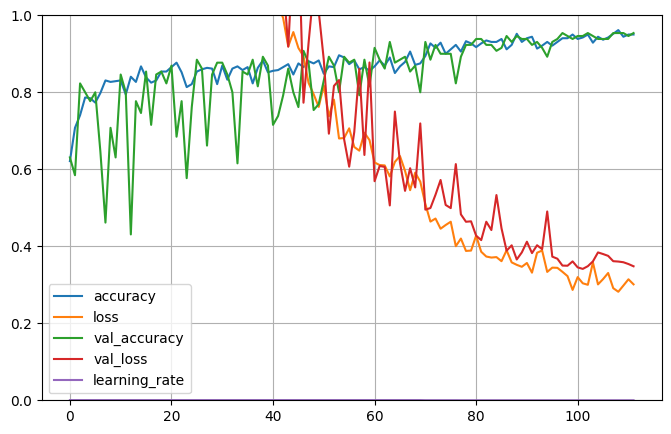

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Qui infine valuto come il modello si comporta su dati che non ha mai visto.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_audio, test_labels, batch_size=16)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9161 - loss: 0.4460


Infine vado a creare la matrice di confusione(che indica nel dettaglio le predizioni corrette e sbagliate) e un istogramma che analizza precision, recall e F1-Score.

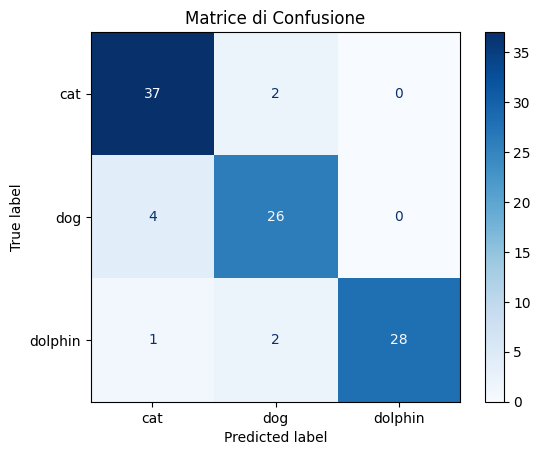

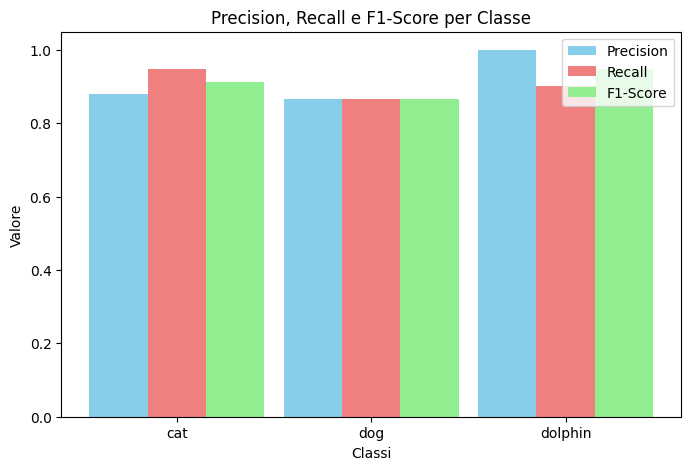

In [ ]:
y_pred = model.predict(test_audio)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

precision = [report[label]["precision"] for label in class_names]
recall = [report[label]["recall"] for label in class_names]
f1_score = [report[label]["f1-score"] for label in class_names]

x = np.arange(len(class_names))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, precision, width, label="Precision", color="skyblue")
ax.bar(x, recall, width, label="Recall", color="lightcoral")
ax.bar(x + width, f1_score, width, label="F1-Score", color="lightgreen")

ax.set_xlabel("Classi")
ax.set_ylabel("Valore")
ax.set_title("Precision, Recall e F1-Score per Classe")
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()


# Modello 2 - Analisi dello spettrogramma

In questo secondo modello prendo in input le forme d'onda e le trasformo in spettrogrammi prima di procedere all'addestramento del modello. Questi possono essere visti come dati che hanno una struttura a griglia con topologia 2D. Per il training di questo modello non è necessaria la GPU, ma è consigliata per una computazione più rapida.


In [ ]:
mel_spec_layer = layers.MelSpectrogram(
    fft_length=2048,
    sequence_stride=512,
    sequence_length=None,
    window="hann",
    sampling_rate=16000,
    num_mel_bins=128,
    min_freq=20.0,
    max_freq=None,
    power_to_db=True,
    top_db=80.0,
    mag_exp=2.0,
    min_power=1e-10,
    ref_power=1.0
)

Etichetta:  [1. 0. 0.]
Etichetta decodificata:  cat


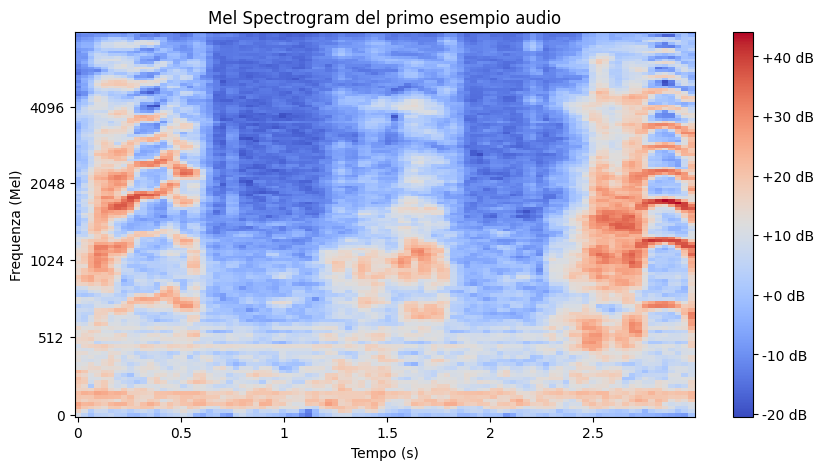

In [ ]:
i=0
sample_audio = train_audio[i]
print("Etichetta: ", train_labels[i].numpy())
label_index = tf.argmax(train_labels[i], axis=-1).numpy()
print("Etichetta decodificata: ", class_names[label_index])

mel_spectrogram = mel_spec_layer(tf.expand_dims(sample_audio, axis=0))[0].numpy()

plt.figure(figsize=(10, 5))
librosa.display.specshow(
    mel_spectrogram,
    sr=16000,
    hop_length=512,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram del primo esempio audio")
plt.xlabel("Tempo (s)")
plt.ylabel("Frequenza (Mel)")
plt.show()


Per affronatare questo problema ho deciso di utilizzare una CNN, in quanto gli spettrogrammi sono rappresentazioni bidimensionali simili a delle immagini e le CNN sono perfette per individuare pattern locali in questi tipi di rappresentazioni.

Per prima cosa ho usato un layer lambda per applicare la funzione mel_spec_layer ai dati audio, l'output è uno spettrogramma Mel bidimensionale.

Successivamente ho utilizzato un altro layer lambda per specificare la profondità del canale, nel caso particolare 1.

Poi applico tre blocchi convoluzioni con uno specifico numero di filtri e specificata dimensione del kernel. Ogni blocco applica:


*   Una convoluzione bidimensionale con ReLu e padding per non diminuire le dimensioni di input e regolarizzazione l2 per ridurre il rischio di overfitting
*   BatchNormalization per stabilizzare il training
*   MaxPooling per ridurre le dimensioni
*   Dropout per prevenire overfitting

I filtri man mano sono in numero maggiore e la finestra di convoluzione si restringe per catturare dettagli a grana più fine.

Successivamente calcolo il GlobalAveragePooling ed il GlobalMaxPooling e li concateno per una rappresentazione più completa.

Infine utilizzo un livello completamente connesso con ReLu come funzione d'attivazione per la non linearità, applico il dropout per una migliore generalizzazione dei risultati ed per evitare overfitting. Utilizzo poi la softmax per ottenere una distribuzione di probabilità sulle classi.


In [ ]:
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Lambda(lambda audio: mel_spec_layer(tf.expand_dims(audio, axis=0))[0])(inputs)
    x = Lambda(lambda t: tf.expand_dims(t, axis=-1))(x)

    x = Conv2D(32, (5, 5), activation="relu", padding="same", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (5, 5), activation="relu", padding="same", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)

    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Concatenate()([avg_pool, max_pool])

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.6)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In questa fase vi è la preparazione e la compilazione del modello, inoltre eseguo la funzione summary() sul modello in modo da averne una visione globale. Ho usato l'ottimizzatore Adam con un passo per aggiornare i pesi molto piccolo, per la loss ho utilizzato la categorical cross-entropy per misurare quanto il modello si discosti dalle labels reali durante l'addestramento, il modello tanto più si discosta, tanto più viene penalizzato. Infine come metrica ho definito l'accuratezza, che valuta la percentuale di predizioni corrette fatte dal modello.

In [ ]:
input_shape = (48000,)
num_classes = len(class_names)

model = create_cnn_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 48000)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_76 (Lambda)        │ (None, 128, 94)        │              0 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_77 (Lambda)        │ (None, 128, 94, 1)     │              0 │ lambda_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 128, 94, 32)    │            832 │ lambda_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 128, 94, 32)    │            128 │ conv2d_105[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_85          │ (None, 64, 47, 32)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_72 (Dropout)      │ (None, 64, 47, 32)     │              0 │ max_pooling2d_85[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 64, 47, 64)     │         51,264 │ dropout_72[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 64, 47, 64)     │            256 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_86          │ (None, 32, 23, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_73 (Dropout)      │ (None, 32, 23, 64)     │              0 │ max_pooling2d_86[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 32, 23, 128)    │         73,856 │ dropout_73[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 32, 23, 128)    │            512 │ conv2d_107[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_87          │ (None, 16, 11, 128)    │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_74 (Dropout)      │ (None, 16, 11, 128)    │              0 │ max_pooling2d_87[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ dropout_74[0][0]       │
│ (GlobalAveragePooling

 Total params: 193,411 (755.51 KB)

 Trainable params: 192,963 (753.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="categorical_crossentropy", metrics=["accuracy"])

Qui addestro il modello, utilizzo l'early stopping per evitare l'overfitting e migliorare l'efficienza nell'addestramento, il valore osservato è la validation loss e, se non vi è un miglioramento per un determinato numero di epoche, l'addestramento viene interrotto ripristinando i pesi trovati per il valore migliore. Inoltre se non vi è un miglioramento per un altro determinato numero di epoche il learning rate viene diminuito in modo da migliorare convergenza e oscillazioni.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.35,
    patience=6,
    min_lr=1e-6,
)
history = model.fit(
    train_audio, train_labels,
    epochs=150,
    batch_size=32,
    validation_data=(val_audio, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 412ms/step - accuracy: 0.3437 - loss: 8.8353 - val_accuracy: 0.4000 - val_loss: 3.5259 - learning_rate: 5.0000e-04
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5214 - loss: 3.8480 - val_accuracy: 0.5154 - val_loss: 2.7129 - learning_rate: 5.0000e-04
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5907 - loss: 2.8997 - val_accuracy: 0.5308 - val_loss: 2.5311 - learning_rate: 5.0000e-04
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6689 - loss: 2.3145 - val_accuracy: 0.5692 - val_loss: 2.2737 - learning_rate: 5.0000e-04
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6916 - loss: 2.1205 - val_accuracy: 0.5462 - val_loss: 2.3506 - learning_rate: 5.0000e-04
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7062 - loss: 2.0304 - val_accuracy: 0.5692 - val_loss: 2.1688 - learning_rate: 5.0000e-04
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy

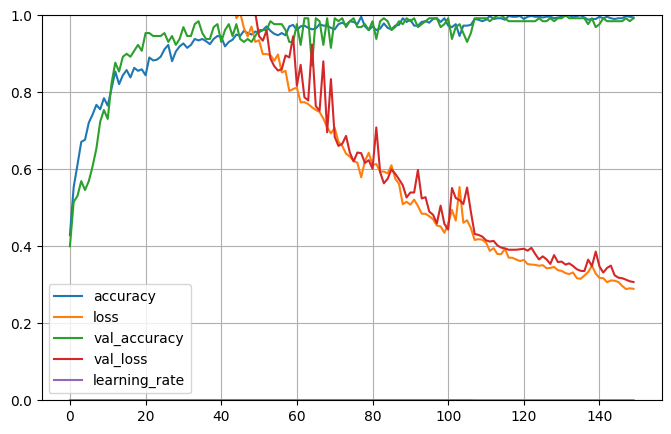

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Qui infine valuto come il modello si comporta su dati che non ha mai visto.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_audio, test_labels, batch_size=16)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9862 - loss: 0.3329  


Infine vado a creare la matrice di confusione(che indica nel dettaglio le predizioni corrette e sbagliate) e un istogramma che analizza precision, recall e F1-Score.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step


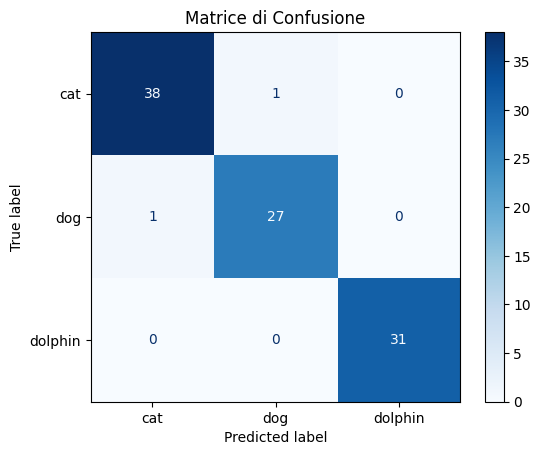

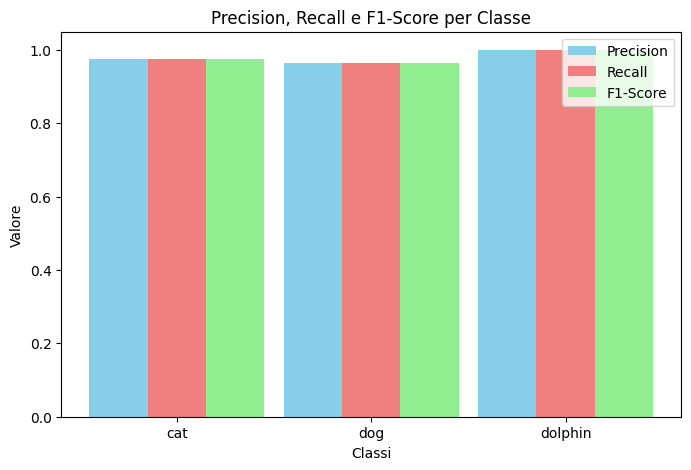

In [ ]:
y_pred = model.predict(test_audio)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

precision = [report[label]["precision"] for label in class_names]
recall = [report[label]["recall"] for label in class_names]
f1_score = [report[label]["f1-score"] for label in class_names]

x = np.arange(len(class_names))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, precision, width, label="Precision", color="skyblue")
ax.bar(x, recall, width, label="Recall", color="lightcoral")
ax.bar(x + width, f1_score, width, label="F1-Score", color="lightgreen")


ax.set_xlabel("Classi")
ax.set_ylabel("Valore")
ax.set_title("Precision, Recall e F1-Score per Classe")
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()
